In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

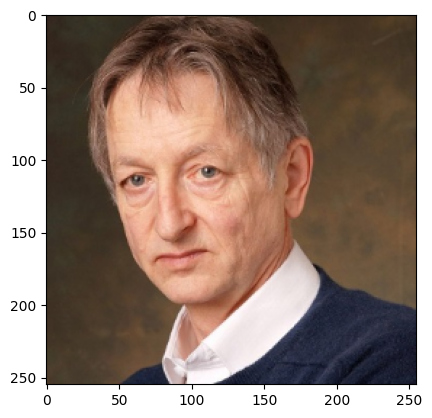

In [2]:
image_path = 'project-files/images/hinton.jpg'

image = plt.imread(image_path)
image = cv2.resize(image, (255, 255))

plt.imshow(image)

In [3]:
def Conv2D(img, filters, stride=1, padding='same'):
    if len(img.shape) == 2:
        img = np.expand_dims(img, axis=-1)
    h, w, channels = img.shape
    n = filters.shape[0]
    f = filters.shape[1]

    p = 0
    if padding == 'same':
        p = (f-1)//2
    padded_image = np.pad(img, ((p, p), (p, p), (0, 0)))

    new_h = (h + 2*p - f)//stride + 1
    new_w = (w + 2*p - f)//stride + 1

    dup_filters = np.expand_dims(filters, axis=-1)
    dup_filters = np.tile(dup_filters, channels)

    output_image = np.zeros((new_h, new_w, n))

    
    for i in range(new_h):
        for j in range(new_w):
            roi = padded_image[i*stride:(i*stride + f), j*stride:(j*stride + f)]
                
            output_image[i, j] = np.sum(roi * dup_filters, axis=(1,2,3))

    return output_image


def MaxPooling2D(img, window=(2, 2), stride=2):
    if len(img.shape) == 2:
        img = np.expand_dims(img, axis=-1)

    h, w, channels = img.shape
    
    new_h = (h - window[0])//stride + 1
    new_w = (w - window[1])//stride + 1

    output_image = np.zeros((new_h, new_w, channels))

    for i in range(new_h):
        for j in range(new_w):
            roi = img[i*stride:(i*stride + window[0]), j*stride:(j*stride + window[1])]
            output_image[i, j] = np.max(roi, axis=(0,1,2))

    return output_image

In [4]:
########## LAYER ONE KERNELS #############
bottom_sobel = np.array(
                    [[-1,-2,-1],
                    [0, 0, 0],
                    [1, 2, 1]])
               
top_sobel = np.array(
                [[1, 2, 1],
                [0, 0, 0],
                [-1,-2,-1]])

sharpening = np.array(
                [[0,-1,0],
                [-1,5,-1],
                [0,-1,0]])

weighted_averaging_3x3 = (1/16)*np.array(
                                [[1, 2, 1],
                                [2, 4, 2],
                                [1, 2, 1]])

############## LAYER TWO KERNELS ###########
robert_x = np.array(
            [[1, 0],
            [0, -1]]) 

robert_y = np.array(
            [[0, +1],
            [-1, 0]] )

averaging_2x2 = (1/4)*np.array(
                        [[1, 1],
                        [1, 1]])


############# LAYER THREE KERNELS ##############
gaussian_5x5 = (1/273)*np.array(
                        [[1,4,7,4,1],
                        [4,16,26,16,4],
                        [7,26,41,26,7],
                        [4,16,26,16,4],
                        [1,4,7,4,1]])


averaging_5x5 = (1/25)*np.ones((5, 5))

In [5]:
l1_filters = np.array([
            bottom_sobel,
            top_sobel,
            sharpening,
            weighted_averaging_3x3])

l2_filters = np.array([
            robert_x,
            robert_y,
            averaging_2x2])

l3_filters = np.array([
            gaussian_5x5,
            averaging_5x5])


layer_one_output = Conv2D(image, l1_filters, stride=1, padding='same')
layer_two_output = Conv2D(layer_one_output, l2_filters, stride=2, padding='valid')
layer_three_output = Conv2D(layer_two_output, l3_filters, stride=1, padding='same')

pooling_output = MaxPooling2D(layer_three_output, window=(2, 2), stride=2)

#### <font color='yellow'>Normalize</font>

In [6]:
# layer_one_output = ((layer_one_output - layer_one_output.min()) / (layer_one_output.max() - layer_one_output.min())) * 255
# layer_two_output = ((layer_two_output - layer_two_output.min()) / (layer_two_output.max() - layer_two_output.min())) * 255
# layer_three_output = ((layer_three_output - layer_three_output.min()) / (layer_three_output.max() - layer_three_output.min())) * 255
# pooling_output = ((pooling_output - pooling_output.min()) / (pooling_output.max() - pooling_output.min())) * 255

In [7]:
image_gray = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
image_gray = cv2.resize(image_gray, (255, 255))

np.save('outputs/image_gray.npy', image_gray)
np.save('outputs/layer_one_output.npy', layer_one_output)
np.save('outputs/layer_two_output.npy', layer_two_output)
np.save('outputs/layer_three_output.npy', layer_three_output)
np.save('outputs/pooling_output.npy', pooling_output)

#### <font color='yellow'>Layer 1</font>

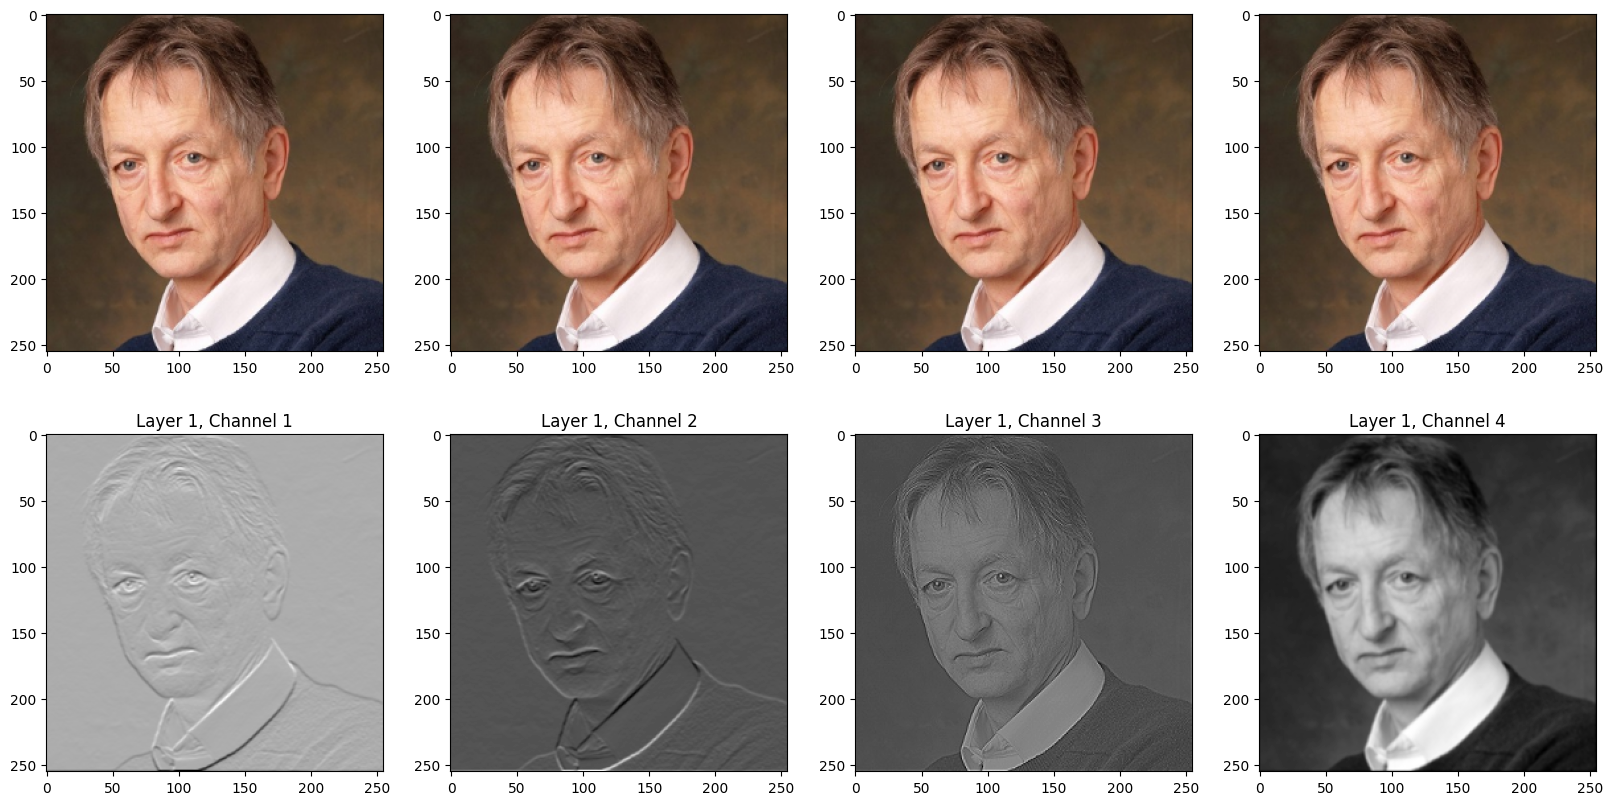

In [8]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
for i in range(4):
    axes[0, i].imshow(image)
    
for i in range(4):
    axes[1, i].imshow(layer_one_output[:,:,i], cmap='gray')
    axes[1, i].set_title('Layer 1, Channel {}'.format(i+1))

plt.show()

#### <font color='yellow'>Layer 2</font>

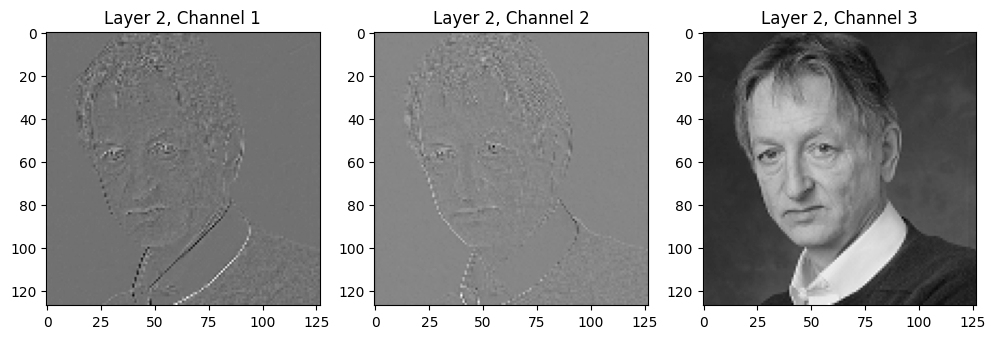

In [9]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
for i in range(3):
    axes[i].imshow(layer_two_output[:,:,i], cmap='gray')
    axes[i].set_title('Layer 2, Channel {}'.format(i+1))

plt.show()

#### <font color='yellow'>Layer 3</font>

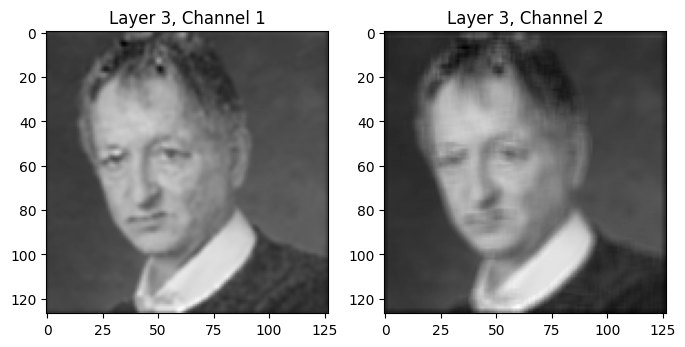

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
for i in range(2):
    axes[i].imshow(layer_three_output[:,:,i], cmap='gray')
    axes[i].set_title('Layer 3, Channel {}'.format(i+1))

plt.show()

#### <font color='yellow'>MaxPooling</font>

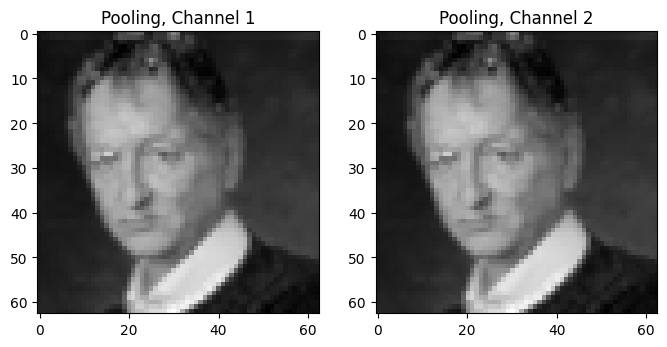

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
for i in range(2):
    axes[i].imshow(pooling_output[:,:,i], cmap='gray')
    axes[i].set_title('Pooling, Channel {}'.format(i+1))

plt.show()